# Raw Indeed Data Parsing and Zero Shot Classification
## Written by Leah Ryu and Michelle Chen
After scraping Indeed reviews from the Internet, we have some Google sheets which store some columned data on each review, which includes but is not limited to author info, title, pros, cons, and content (general review body without specified valence). We will take the sheet for one company as input and parse it into a list of pros sentences, a list of cons sentences, and a list of neutral sentences. To do so, we'll need to decide what constitutes one sentence when it comes to parsing. Finally, we'll run zero shot classification on each pros/cons/neutral sentence, storing the pros/cons/neutrals sorted by topic into respective files. We'll also make sure to store the corresponding review dates for each sentence in a separate file. 

Importing data from Google Sheets Referencing snippet from here: https://colab.research.google.com/notebooks/snippets/sheets.ipynb#scrollTo=JiJVCmu3dhFa

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
worksheet = gc.open('allActivisionBlizzardIndeed').sheet1

In [ ]:
rows = worksheet.get_all_values()
print(rows)

[['title', 'author_type', 'content', 'rating', 'pros', 'cons'], ['Ok', 'Audio Visual Assistant (Former Employee) - Los Angeles, CA - January 21, 2021', 'If you plan to make this a temporary job its not meant for you nor a career... But i do recommend to all that are so passionate and hard workers that are experienced at what they do work smarter not harder the pay wasnt good for me but i enjoyed working there i can only imagine what my pay would look like if i got payed more by the hr', '4', '', ''], ['Terrible work environment, Long random hours', 'Quality Assurance Tester (Former Employee) - Minneapolis, MN - April 19, 2022', 'You essentially walk in every day not knowing when you will be allowed to leave. The people in charge of your shift have no idea what will be sent down to them and in turn down to you. You can be left waiting for up to an hour just to hear if you are clear to leave.', '1', 'Free snacks..', 'Time, Well being, instruction is none existent.'], ['Long days but with

Converting the spreadsheet to a Pandas Dataframe

In [ ]:
import pandas as pd

In [ ]:
act_df = pd.DataFrame.from_records(rows)
display(act_df)

In [ ]:
# Designating the first row of the dataframe as the header
act_df.columns = act_df.iloc[0]
act_df = act_df[1:]
act_df.head()

,title,author_type,content,rating,pros,cons
1,Ok,Audio Visual Assistant (Former Employee) - Los...,If you plan to make this a temporary job its n...,4,,
2,"Terrible work environment, Long random hours",Quality Assurance Tester (Former Employee) - M...,You essentially walk in every day not knowing ...,1,Free snacks..,"Time, Well being, instruction is none existent."
3,Long days but with fun people,"QA Tester (Current Employee) - Eden Prairie, M...",The job can definitely be tedious most of the ...,3,,
4,Long hours with no compensation...,"QA Tester (Current Employee) - Minneapolis, MN...",Started around a year ago now and I simply can...,2,"Free Lunch, Time off is super easy to get, Rel...","Long hours, mentally draining, No motivation, ..."
5,I guess if you really love CoD,QA Game Tester (Former Employee) - Eden Prairi...,I was excited to start working in the gaming i...,3,"Sometimes free food and swag, making friends","constant random OT, bro culture, feeling like ..."


In [ ]:
import datetime

In [ ]:
# Helper function for date formatting (MM/DD/YY).
# i.e. Takes "January 1, 2000" as input, and returns "01/01/2000" as output.
# Note that both I/O are strings.
def format_date(original_date):

  date_components = original_date.split(' ')

  # Convert the month from abbreviated to numerical format.
  # Pad zeroes wherever appropriate.
  month = date_components[0][0:3]
  month_published = str(datetime.datetime.strptime(month, "%b").month).zfill(2)

  # Remove the trailing comma from the day (second item in list).
  # Again, pad zeroes wherever appropriate.
  day_published = date_components[1][0:-1].zfill(2)

  year_published = date_components[2]

  date_formatted = month_published + '/' + day_published + '/' + year_published
  return date_formatted

In [ ]:
# Extract the date from the last column
for index, row in act_df.iterrows():

  delimiter = ' - '
  split_info = row['author_type'].split(delimiter)
  
  date_published = ''

  # If a job title was provided by the reviewer, we splice it out.
  date_published = split_info[-1]

  # Format the date, relying on the helper function above.
  date_formatted = format_date(date_published)
  
  # Update the dataframe.
  act_df.loc[index, 'author_type'] = date_formatted

In [ ]:
act_df

# Zero-shot classification

Now, we're going to use zero-shot classification to classify our reviews
according to these axes: Culture and Values, Diversity and Inclusion, Work/Life Balance, Senior Management, Compensation and Benefits, and Career Opportunities. 

To do this, we'll first make a long list of all the sentences from our reviews. 

Then, we'll use BART from Hugging Face (https://huggingface.co/facebook/bart-large-mnli) to classify those sentences, putting them into appropriate lists! We will also keep them separated by negative and positive by assuming that whatever is under "pros" is positive, and whatever is under "cons" can be expected to be negative--this will be useful later on when we begin to use BERT for sentiment analysis. We also keep a list of "neutral" reviews, since an Indeed review looks something like this:


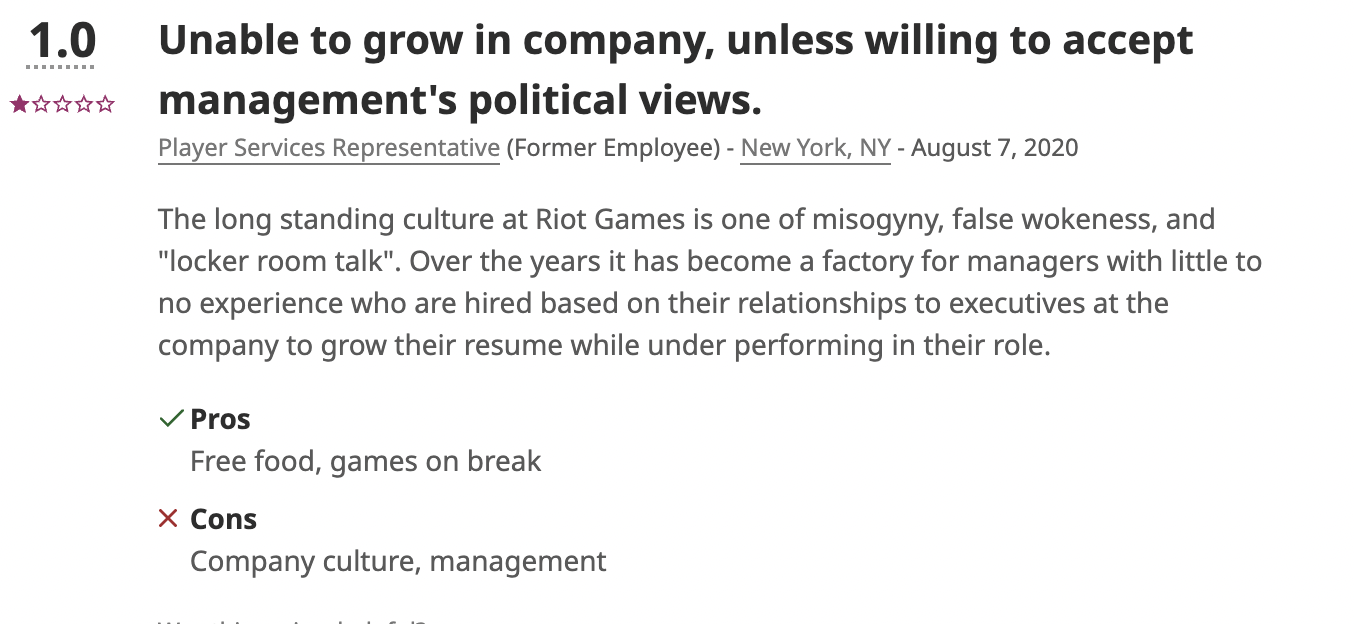

We'll use the trained BERT on this neutral part of the review.

In [ ]:
pip install transformers

In [ ]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
reviewsPro = act_df['pros']            # pros column
reviewsCon = act_df['cons']            # cons column
reviewsNeutral = act_df['content']     # This part of the Indeed review is not labeled.
reviewsDates = act_df['author_type']

Now that we have our data, we need to parse things into sentences. This is a bit tricky--there's no unified format for user reviews. Some people use periods to separate sentences. Some use hyphens. Some use both hyphens and periods, with additional hyphens. When the data is scraped from the Internet, newlines are obliterated, so we can't use those as clues. For Indeed reviews, some reviews don't have pros and cons, so we need to store an empty string in our list at that point so our array indices line up with dates.

Instead, we'll assume that if we encounter a period or an exclamation mark, we're ending a sentence. We'll also assume that if we encounter a hyphen with a space after it, we're ending a sentence. 

In [ ]:
proSentences = []
conSentences = []
neutSentences = []

proDates = []
conDates = []
neutDates = []

def parseSentencesFromReviewsColumnWithDates(reviewsColumnName, reviewsDatesName, reviewsList, datesList):
  # Iterate through the review at each row in the given column.
  for review, date in zip(act_df[reviewsColumnName], act_df[reviewsDatesName]): 
    currSent = ""

    # If the field is empty, we'll just append an empty string.
    if not review:
      reviewsList.append("")
      datesList.append(date)
      continue

    prevChar = review[0]
    # columnData = one full positive review section. Loop thru char by char
    for character in review:
      # If we encounter a period, assume sentence, but only if the built string is
      # not spaces and not empty.
      if character == '.':
        if currSent.strip("-. ") and not currSent.strip(",. ").isspace():
          reviewsList.append(currSent.strip("-."))
          datesList.append(date)
        currSent = ""
      # If we encounter a "- ", assume sentence.
      elif character == ' ' and prevChar == '-':
        if currSent.strip("-. ") and not currSent.strip(",. ").isspace():
          reviewsList.append(currSent.strip(".-"))
          datesList.append(date)
      
        currSent = ""
    
      # Keep building the string and keep track of the prev char.
      currSent += character
      prevChar = character
      
    # Append whatever was left if it wasn't already caught
    if currSent.strip("-. ") and not currSent.strip(",. ").isspace():
      reviewsList.append(currSent.strip(".-"))
      datesList.append(date)

In [ ]:
# Run this cell only once!

# Run on pos, neg, neutral reviews
parseSentencesFromReviewsColumnWithDates('pros', 'author_type', proSentences, proDates)
parseSentencesFromReviewsColumnWithDates('cons', 'author_type', conSentences, conDates)
parseSentencesFromReviewsColumnWithDates('content', 'author_type', neutSentences, neutDates)

# # Sanity check
print(proSentences[:15])
print(conSentences[:15])
print(neutSentences[:15])

print(len(proSentences))
print(len(conSentences))
print(len(neutSentences))

print(proDates[:15])
print(conDates[:15])
print(neutDates[:15])

print(len(proDates))
print(len(conDates))
print(len(neutDates))

['', 'Free snacks', '', 'Free Lunch, Time off is super easy to get, Relaxed Work Environment, Nice People', 'Sometimes free food and swag, making friends', '', 'If you have a good manager, it helps things a LOT', ' The people are extremely kind', 'Work Schedule', 'Free lunch, close to home, flexible with time off', '16 hour average work days 7 days a week during crunch periods lasting for several months, poverty level pay for the area in Irvine California, Management staff are generally family members or friends with no previous management education, experience or training', '', 'None', 'Free snacks and drinks, decent pay', '']
['', 'Time, Well being, instruction is none existent', '', 'Long hours, mentally draining, No motivation, Not good benefits', 'constant random OT, bro culture, feeling like a tiny cog', '', "Tons of re-orgs, upper management is a mess (don't listen to employees at all), impossible to get promoted", 'Prejudiced atmosphere', 'No room for advancement really', '', '

In [ ]:
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from pprint import pprint

In [ ]:
lemmatizer = WordNetLemmatizer()

def tokenizeLemmatize(reviews):
  temp = []
  for sentence in reviews:
    tokens = word_tokenize(sentence)
    cleanedSentence = ""
    for token in tokens:
        lemmetized_word = lemmatizer.lemmatize(token)
        cleanedSentence += lemmetized_word + " "
    temp.append(cleanedSentence)
  return temp

In [ ]:
proSentencesCleaned = tokenizeLemmatize(proSentences)
conSentencesCleaned = tokenizeLemmatize(conSentences)
neutSentencesCleaned = tokenizeLemmatize(neutSentences)

# Sanity check
print(proSentencesCleaned)
print(conSentencesCleaned)
print(neutSentencesCleaned)

['', 'Free snack ', '', 'Free Lunch , Time off is super easy to get , Relaxed Work Environment , Nice People ', 'Sometimes free food and swag , making friend ', '', 'If you have a good manager , it help thing a LOT ', 'The people are extremely kind ', 'Work Schedule ', 'Free lunch , close to home , flexible with time off ', '16 hour average work day 7 day a week during crunch period lasting for several month , poverty level pay for the area in Irvine California , Management staff are generally family member or friend with no previous management education , experience or training ', '', 'None ', 'Free snack and drink , decent pay ', '', '', 'Free Lunches at least once a month , TV and game system in break room , Lots of Overtime possibility ', '', 'The people ', 'Sense of accomplishment , no dress code ', 'Coworkers are like minded , Being in the know is ', 'Getting paid to play video game ', 'Easy to get drug if your into that ', 'Sometimes offer free meal , good overtime pay , unique 

Now we're all set up to classify our sentences. We'll sort them into lists according to their valence and category (the six categories are given under "Zero-shot classification)--12 lists in total.

In [ ]:
# These are the possible categories of relevance we have defined.
# Diversity and inclusion = 1
# Culture and values = 2
# Work life balance = 3
# Senior management = 4
# Career opportunities = 5
# Compensation and benefits = 6
candidate_labels = ['diversity and inclusion', 'culture and values', 'work life balance', 'senior management', 'career opportunities', 'compensation and benefits']

pros = [[], [], [], [], [], []]
cons = [[], [], [], [], [], []]
neutrals = [[], [], [], [], [], []]

datesListPro = [[], [], [], [], [], []]
datesListCon = [[], [], [], [], [], []]
datesListNeut = [[], [], [], [], [], []]

# Let's be picky and assume that if the top value is lower than 0.4, the
# sentence is not relevant.

def sortReviewSentencesUsingZeroShot(sentenceList, datesList, labeledContainers, datesContainers):
  for i in range(len(sentenceList)):
    sentence = sentenceList[i]

    # If the sentence is empty, just continue on (this may happen when a review)
    # didn't have pros and cons
    if not sentence:
      continue

    date = datesList[i]
    cat = classifier(sentence, candidate_labels)
    if float(cat['scores'][0]) > 0.4:
      label = cat['labels'][0]
      if label == candidate_labels[0]:
        labeledContainers[0].append(sentence)
        datesContainers[0].append(date)
      elif label == candidate_labels[1]:
        labeledContainers[1].append(sentence)
        datesContainers[1].append(date)
      elif label == candidate_labels[2]:
        labeledContainers[2].append(sentence)
        datesContainers[2].append(date)
      elif label == candidate_labels[3]:
        labeledContainers[3].append(sentence)
        datesContainers[3].append(date)
      elif label == candidate_labels[4]:
        labeledContainers[4].append(sentence)
        datesContainers[4].append(date)
      elif label == candidate_labels[5]:
        labeledContainers[5].append(sentence)
        datesContainers[5].append(date)
      

In [ ]:
# Libraries needed to import/export files from/to drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Each list item is written on a separate line: lists within the list are 
# separated with the token "[LISTSEP]". For the filepath, you need to 
# input a directory that already exists in your drive. (e.g., 
# /content/drive/MyDrive/folderYouCreated/fileNameYouWant)

def writeListOfListsToFile(listThingy, filePath):
  with open(filePath, 'w') as writefile:
    for oneList in listThingy:
      for element in oneList:
        writefile.write(element)
        writefile.write('\n')
      writefile.write("[LISTSEP]\n")

In [ ]:
sortReviewSentencesUsingZeroShot(proSentencesCleaned, proDates, pros, datesListPro)
writeListOfListsToFile(pros, '/content/drive/MyDrive/compling_final/activisionProsIndeedClassified.txt')
writeListOfListsToFile(datesListPro, '/content/drive/MyDrive/compling_final/activisionProsIndeedDates.txt')

In [ ]:
sortReviewSentencesUsingZeroShot(conSentencesCleaned, conDates, cons, datesListCon)
writeListOfListsToFile(cons, '/content/drive/MyDrive/compling_final/activisionConsIndeedClassified.txt')
writeListOfListsToFile(datesListCon, '/content/drive/MyDrive/compling_final/activisionConsIndeedDates.txt')

In [ ]:
sortReviewSentencesUsingZeroShot(neutSentencesCleaned, neutDates, neutrals, datesListNeut)
writeListOfListsToFile(neutrals, '/content/drive/MyDrive/compling_final/activisionNeutralsIndeedClassified.txt')
writeListOfListsToFile(datesListNeut, '/content/drive/MyDrive/compling_final/activisionNeutralsIndeedDates.txt')